# Sentiment Analysis Demo

This Notebook use the dataset that crawled from TripAdvisor relate to Vietnam Airline in 2023.
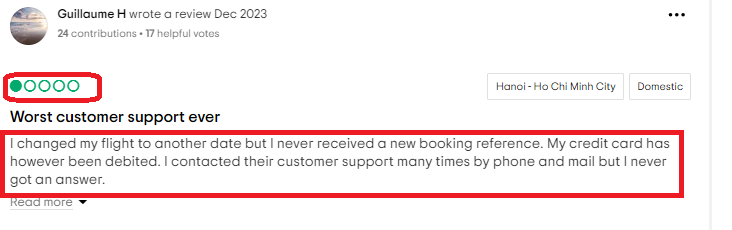


Link: https://www.tripadvisor.com/Airline_Review-d8729180-Reviews-Vietnam-Airlines

***We demo use two main sentiment analysis methods:***
- Method 1: Use Rule_Based Method
- Method 2: Automatic methods (using ML)

***In addition we apply Topic Modeling to identify topics from review***
- Latent Dirichlet Allocation (LDA)

## Importing the libraries

In [1]:
#!pip install langdetect

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Importing the dataset

In [3]:
# This dataset just include some attributes that need for this demo as: Review and Score
dataset = pd.read_csv('https://raw.githubusercontent.com/calich88/Labs/main/review_vietnamairline.csv')
dataset.head()

,Page,Name,Score,Review
0,1,Patrick F,1,I am highly unhappy with this airline! The Web...
1,1,Inda H,2,Called 7 times and no answer nor voice message...
2,1,Sam B,1,They hold on to your your cash while refuse to...
3,1,Therese K,4,"Overall 4 flights. 3 were fine, the all seemed..."
4,1,An K,1,"Summary, please avoid buying Vietnam Airlines ..."


In [4]:
# Creating a new column 'Sentiment_From_Score' based on 'Score'
#
# A value of 2 for scores of 5 and 4  --> Mean Positive
# A value of 1 for a score of 3,      --> Mean Neutral
# A value of 0 for scores of 1 and 2. --> Mean Negative
#

dataset["Sentiment_From_Score"] = dataset["Score"].apply(lambda x: 2 if x >= 4 else (1 if x == 3 else 0))
dataset.head()
print("This dataset has:", dataset.shape[0], "rows")

This dataset has: 4687 rows


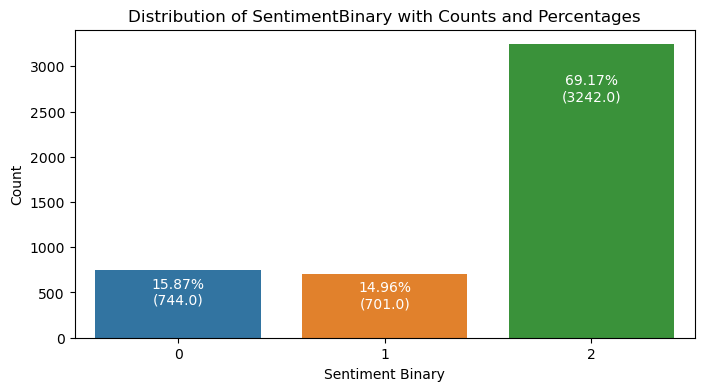

In [5]:
# Create a count plot
plt.figure(figsize=(8, 4))
ax = sns.countplot(x=dataset["Sentiment_From_Score"])

# Adding annotations inside each bar
for p in ax.patches:
    height = p.get_height()
    percentage = 100 * height / len(dataset)
    ax.text(p.get_x() + p.get_width() / 2., height - 0.1 * height, '{:1.2f}%\n({})'.format(percentage, height), ha="center", va='top', color='white')

plt.title("Distribution of SentimentBinary with Counts and Percentages")
plt.xlabel("Sentiment Binary")
plt.ylabel("Count")
plt.show()

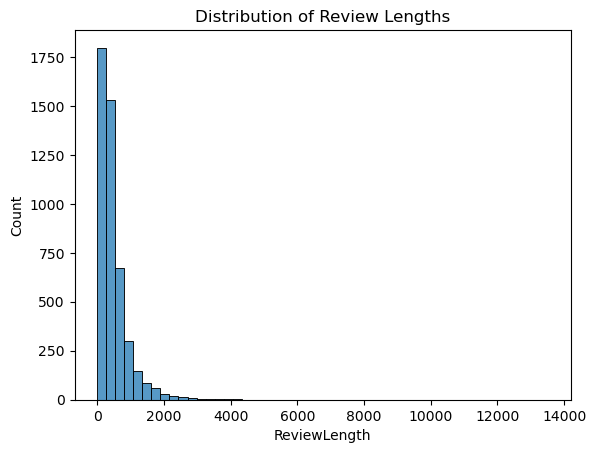

In [6]:
dataset['ReviewLength'] = dataset['Review'].apply(len)
sns.histplot(dataset['ReviewLength'], bins=50)
plt.title('Distribution of Review Lengths')
plt.show()

## Pre-Processing Text

In [7]:
# Required imports
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

# Download required NLTK resources once
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Assuming 'dataset' is a DataFrame with a column 'Review'
text_data = dataset['Review']

# Preprocessing function
def preprocess_text(text_data):
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    from nltk.stem import WordNetLemmatizer

    # Initialize tokenizer and lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Convert to lowercase
    text_data = text_data.lower()

    # Tokenization
    tokens = word_tokenize(text_data)

    # Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Stop words removal
    stop_words_set = set(stopwords.words("english"))
    # Define additional stop words
    additional_stop_words = ["n't", "isnt", '...']
    extended_stop_words = stop_words_set.union(additional_stop_words)
    # Filter tokens
    tokens = [token for token in tokens if token not in extended_stop_words and len(token) >= 3]

    # Join tokens back into a single string
    return " ".join(tokens)

# Preprocess the text data
dataset['Review_Clean'] = text_data.apply(preprocess_text)

# Text vectorization with TF-IDF
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
text_matrix = vectorizer.fit_transform(dataset['Review_Clean'])
feature_names = vectorizer.get_feature_names_out()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zhd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zhd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zhd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
dataset = dataset[['Review_Clean', 'Sentiment_From_Score']]

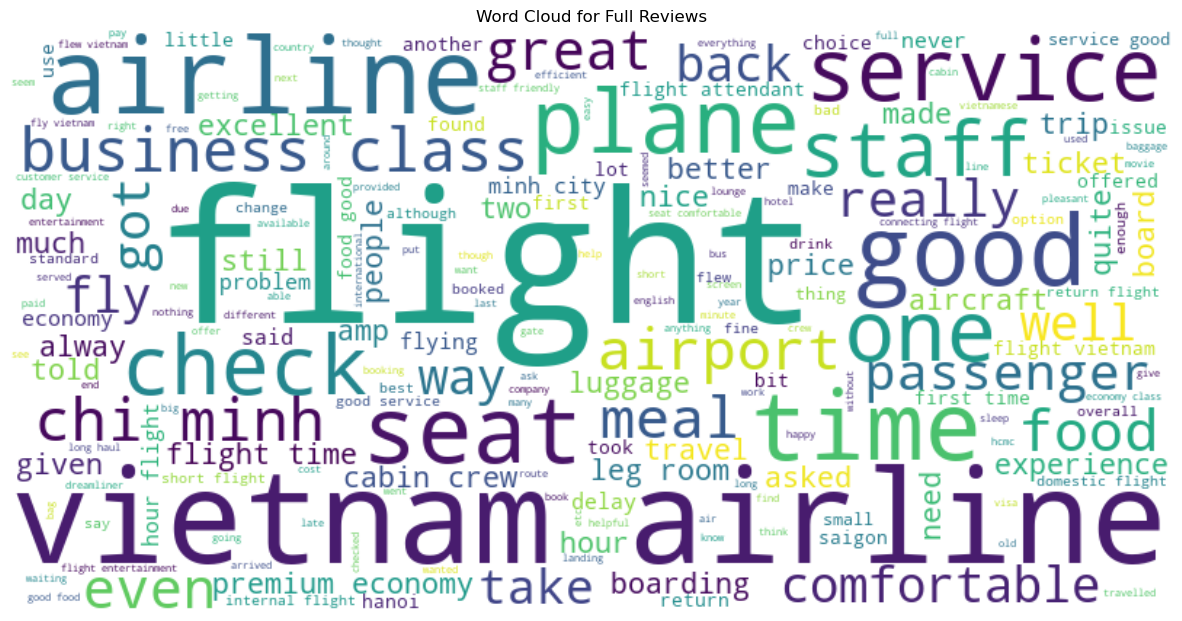

In [9]:
# Import necessary libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'FullReview' is the column with text data
# Generate the word cloud
wordcloud = WordCloud(background_color='white',
                      max_words=200,
                      contour_width=3,
                      contour_color='steelblue',
                      width=800,  # Width of the canvas
                      height=400  # Height of the canvas
                     ).generate(' '.join(dataset['Review_Clean'].astype(str)))

# Display the word cloud using matplotlib
plt.figure(figsize=(15, 8))  # Size of the figure
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Full Reviews')

# Save the figure in high resolution
plt.savefig('wordcloud_high_res.png', format='png', dpi=300)  # Save in high resolution

# To display the plot (if you're using a Jupyter notebook)
plt.show()

# Part 1: Sentiment Analysis

# Method 1: Use Rule_Based Method


Usually, a rule-based system uses a set of human-crafted rules to help identify subjectivity, polarity, or the subject of an opinion.

These rules may include various NLP techniques developed in computational linguistics, such as:

- Stemming, tokenization, part-of-speech tagging and parsing.
- Lexicons (i.e. lists of words and expressions).
Here’s a basic example of how a rule-based system works:

- Defines two lists of polarized words (e.g. negative words such as bad, worst, ugly, etc and positive words such as good, best, beautiful, etc).
- Counts the number of positive and negative words that appear in a given text.

If the number of positive word appearances is greater than the number of negative word appearances, the system returns a positive sentiment, and vice versa. If the numbers are even, the system will return a neutral sentiment.

***VADER Sentiment Analysis***

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media, and works well on texts from other domains.


In [10]:
# Install if not
#!pip install vaderSentiment

In [11]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\zhd\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [12]:
# To demo this, copy only review
data_notlabel = dataset[['Review_Clean']].copy()
data_notlabel

,Review_Clean
0,highly unhappy airline website big mess wanted...
1,called time answer voice message said policy r...
2,hold cash refuse refund form voucher immediate...
3,overall flight fine seemed leave late always a...
4,summary please avoid buying vietnam airline do...
...,...
4682,check-in smooth flight prompt cabin crew court...
4683,experience vietnam airline definitely positive...
4684,used airline two occasion found outstanding th...
4685,made flight stand apart airline 've flown lond...


## Aspect-Based Sentiment Analysis (ABSA)

In [13]:
#!pip install spacy
#!python -m spacy download en_core_web_sm


In [14]:
import numpy as np
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

# Load spaCy model
nlp = spacy.load("en_core_web_sm")  # For English language

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Modified function for aspect extraction, sentiment analysis, and sentiment labeling
def analyze_aspect_sentiments_and_label(text):
    # Parse the text with spaCy
    doc = nlp(text)
    
    # Extract candidate aspects
    candidate_aspects = [chunk.text.lower() for chunk in doc.noun_chunks]

    # Dictionary to hold aspects, their sentiments, and labels
    aspect_sentiment_labels = {}

    for aspect in candidate_aspects:
        # Calculate sentiment score for the aspect
        sentiment_score = analyzer.polarity_scores(aspect)['compound']
        
        # Determine sentiment label based on the score
        sentiment_label = 'positive' if sentiment_score > 0 else ('negative' if sentiment_score < 0 else 'neutral')
        
        if aspect in aspect_sentiment_labels:
            aspect_sentiment_labels[aspect]['Scores'].append(sentiment_score)
            aspect_sentiment_labels[aspect]['Labels'].append(sentiment_label)
        else:
            aspect_sentiment_labels[aspect] = {'Scores': [sentiment_score], 'Labels': [sentiment_label]}

    # Aggregate scores and decide the predominant sentiment for each aspect
    for aspect in aspect_sentiment_labels:
        avg_score = np.mean(aspect_sentiment_labels[aspect]['Scores'])
        predominant_label = max(set(aspect_sentiment_labels[aspect]['Labels']), key=aspect_sentiment_labels[aspect]['Labels'].count)
        aspect_sentiment_labels[aspect] = {'Score': avg_score, 'Label': predominant_label}
    
    return aspect_sentiment_labels
# Apply aspect-based sentiment analysis
data_notlabel['AspectSentiments'] = data_notlabel['Review_Clean'].apply(analyze_aspect_sentiments_and_label)

# Initialize VADER's SentimentIntensityAnalyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

# Apply sentiment analysis to get the compound score
data_notlabel['Sentiment_Rule_Based'] = data_notlabel['Review_Clean'].apply(lambda review: sentiment_analyzer.polarity_scores(review)['compound'])

# Classify the compound score into sentiment types
data_notlabel['Sentiment_Types'] = data_notlabel['Sentiment_Rule_Based'].apply(lambda score: 'positive' if score > 0 else ('negative' if score < 0 else 'neutral'))
# Display the DataFrame with both aspect-based sentiments and overall sentiment types
data_notlabel[['Review_Clean', 'AspectSentiments', 'Sentiment_Rule_Based', 'Sentiment_Types']].head()


,Review_Clean,AspectSentiments,Sentiment_Rule_Based,Sentiment_Types
0,highly unhappy airline website big mess wanted...,{'highly unhappy airline website': {'Score': -...,0.2136,positive
1,called time answer voice message said policy r...,{'called time answer voice message': {'Score':...,-0.6249,negative
2,hold cash refuse refund form voucher immediate...,"{'cash': {'Score': 0.0, 'Label': 'neutral'}, '...",-0.3685,negative
3,overall flight fine seemed leave late always a...,"{'overall flight fine': {'Score': 0.2023, 'Lab...",0.6808,positive
4,summary please avoid buying vietnam airline do...,"{'vietnam airline': {'Score': 0.0, 'Label': 'n...",0.8979,positive


In [15]:
with pd.option_context('display.max_colwidth', None):
    display(data_notlabel[['Review_Clean', 'AspectSentiments', 'Sentiment_Rule_Based', 'Sentiment_Types']].head(2))


,Review_Clean,AspectSentiments,Sentiment_Rule_Based,Sentiment_Types
0,highly unhappy airline website big mess wanted book extra sportluggage thought problem could find term regarding extra price neither could book online furthermore tried get someone phone day person got could speak proper language could help spoke random sentence made sense send e-mail answer could help reply mail link webpage wher could find information. never could would cancel whole holiday wanted kitesurfing gear,"{'highly unhappy airline website': {'Score': -0.4754, 'Label': 'negative'}, 'big mess': {'Score': -0.3612, 'Label': 'negative'}, 'book extra sportluggage thought problem': {'Score': -0.4019, 'Label': 'negative'}, 'term': {'Score': 0.0, 'Label': 'neutral'}, 'extra price': {'Score': 0.0, 'Label': 'neutral'}, 'someone phone day person': {'Score': 0.0, 'Label': 'neutral'}, 'proper language': {'Score': 0.0, 'Label': 'neutral'}, 'random sentence': {'Score': 0.0772, 'Label': 'positive'}, 'sense': {'Score': 0.0, 'Label': 'neutral'}, 'e': {'Score': 0.0, 'Label': 'neutral'}, '-mail answer': {'Score': 0.0, 'Label': 'neutral'}, 'reply mail link webpage wher': {'Score': 0.0, 'Label': 'neutral'}, 'information': {'Score': 0.0, 'Label': 'neutral'}, 'whole holiday': {'Score': 0.4019, 'Label': 'positive'}, 'kitesurfing gear': {'Score': 0.0, 'Label': 'neutral'}}",0.2136,positive
1,called time answer voice message said policy require visa end pay extra visa transit scam,"{'called time answer voice message': {'Score': 0.0, 'Label': 'neutral'}, 'policy': {'Score': 0.0, 'Label': 'neutral'}, 'visa end': {'Score': 0.0, 'Label': 'neutral'}, 'extra visa transit scam': {'Score': -0.5719, 'Label': 'negative'}}",-0.6249,negative


***Results***
As we can see above results, by apply rule-based method that can identify sentiment of the reviews

## Predict a new review

In [16]:
# Assuming 'new_review' is your new text observation
new_review = "This filight is normal"

# Preprocess the new review using your defined function.
new_review_clean = preprocess_text(new_review)

# Initialize an instance of SentimentIntensityAnalyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

# Analyze the sentiment of the new review
sentiment_score = sentiment_analyzer.polarity_scores(new_review_clean)['compound']

# You can then interpret the sentiment_score based on its value:
# compound score >= 0.05 -> positive
# compound score <= -0.05 -> negative
# compound score between -0.05 and 0.05 -> neutral

if sentiment_score >= 0.05:
    sentiment = "Positive"
elif sentiment_score <= -0.05:
    sentiment = "Negative"
else:
    sentiment = "Neutral"

print(f"The sentiment of the new review is: {sentiment} (Score: {sentiment_score})")


The sentiment of the new review is: Neutral (Score: 0.0)


# Method 2: Automatic methods (using ML)

Automatic methods, contrary to rule-based systems, don't rely on manually crafted rules, but on machine learning techniques. A sentiment analysis task is usually modeled as a classification problem, whereby a classifier is fed a text and returns a category, e.g. positive, negative, or neutral.

Here’s how a machine learning classifier can be implemented:

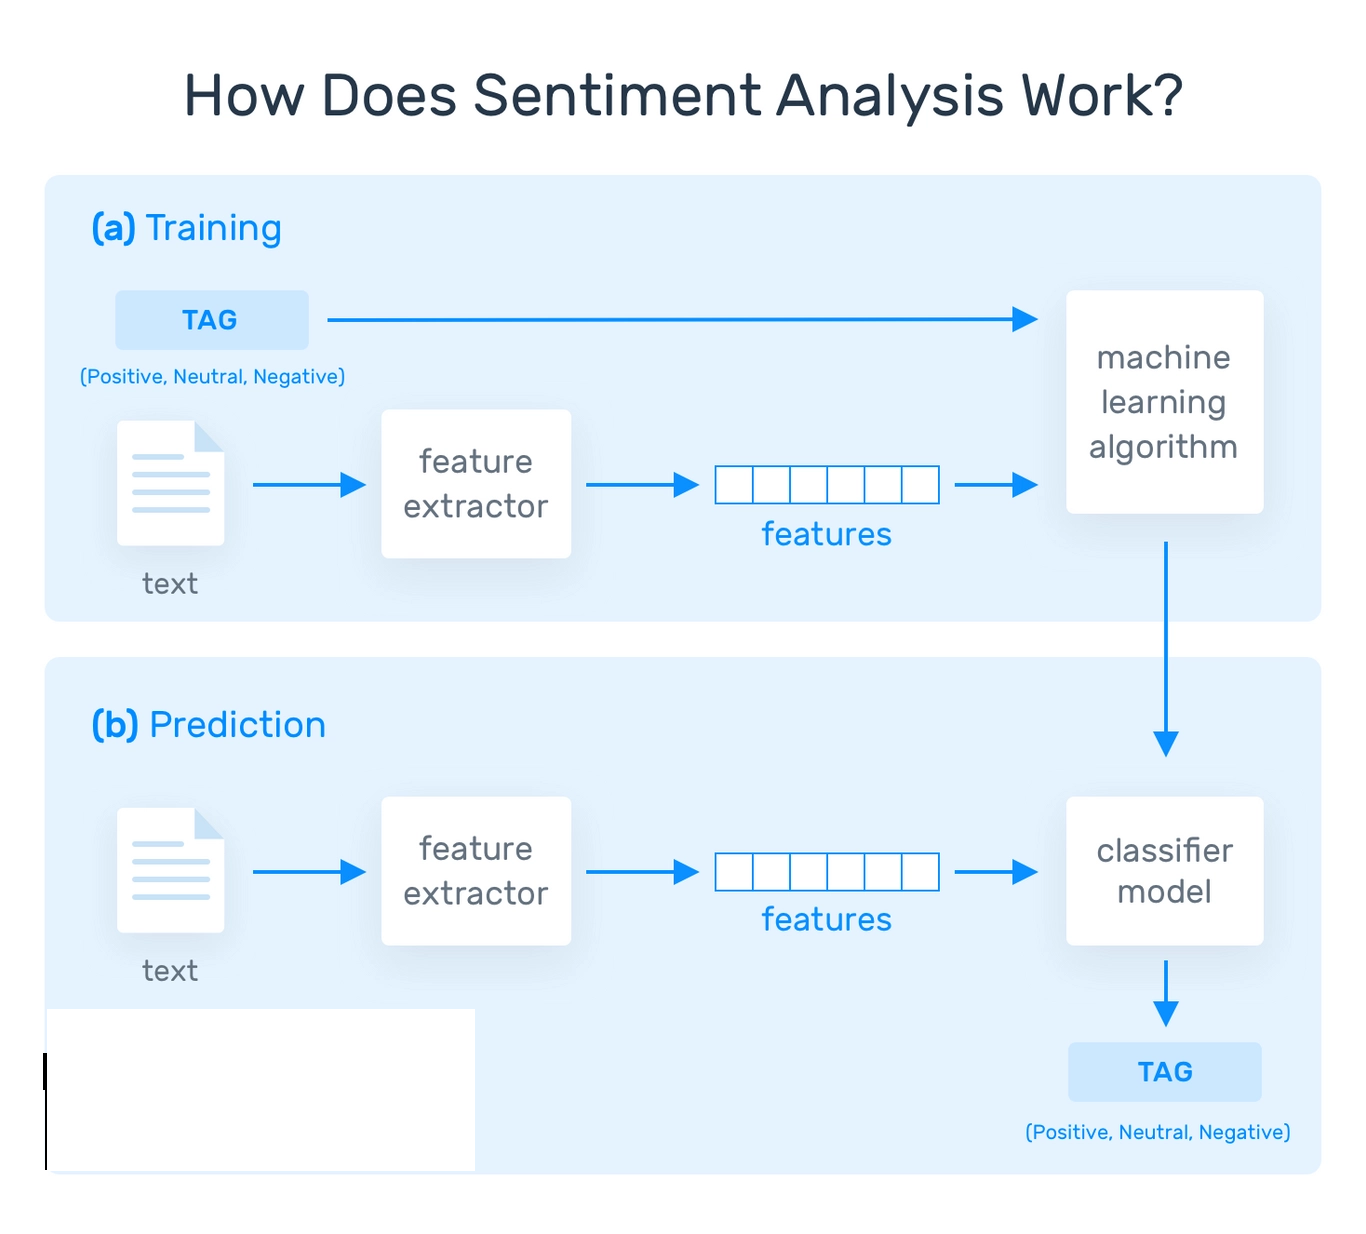

In [17]:
# To demo this, copy dataset include both "Review_clean", "Sentiment_From_Score" (Liked)
data_label = dataset.copy()
data_label

,Review_Clean,Sentiment_From_Score
0,highly unhappy airline website big mess wanted...,0
1,called time answer voice message said policy r...,0
2,hold cash refuse refund form voucher immediate...,0
3,overall flight fine seemed leave late always a...,2
4,summary please avoid buying vietnam airline do...,0
...,...,...
4682,check-in smooth flight prompt cabin crew court...,2
4683,experience vietnam airline definitely positive...,2
4684,used airline two occasion found outstanding th...,2
4685,made flight stand apart airline 've flown lond...,2


In [18]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Prepare data
X = data_label['Review_Clean'].values
y = data_label['Sentiment_From_Score'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define pipeline of models to evaluate
models = [

    ('Logistic Regression', Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)),
        ('clf', LogisticRegression(max_iter=500))
    ])),
    ('Random Forest', Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)),
        ('clf', RandomForestClassifier(n_estimators=200))
    ])),

    ('MLP Neural Network', Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)),
        ('clf', MLPClassifier(hidden_layer_sizes=(100,), max_iter=500))
    ]))
]

# Train and evaluate each model
results = []
for name, model in models:
    print(f'Training {name} model...')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'{name} model - Test accuracy: {model.score(X_test, y_test):.3}')
    print(classification_report(y_test, y_pred))
    results.append((name, model.score(X_test, y_test)))

# Print out the results in a table
print("The final results")
print("{:<25} {:<10}".format('Model', 'Accuracy'))
for name, accuracy in results:
    print("{:<25} {:<10.3f}".format(name, accuracy))

Training Logistic Regression model...
Logistic Regression model - Test accuracy: 0.813
              precision    recall  f1-score   support

           0       0.81      0.68      0.74       153
           1       0.66      0.14      0.23       135
           2       0.82      0.98      0.90       650

    accuracy                           0.81       938
   macro avg       0.76      0.60      0.62       938
weighted avg       0.79      0.81      0.77       938

Training Random Forest model...
Random Forest model - Test accuracy: 0.761
              precision    recall  f1-score   support

           0       0.83      0.45      0.58       153
           1       0.00      0.00      0.00       135
           2       0.75      0.99      0.86       650

    accuracy                           0.76       938
   macro avg       0.53      0.48      0.48       938
weighted avg       0.66      0.76      0.69       938

Training MLP Neural Network model...


C:\Users\zhd\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zhd\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zhd\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MLP Neural Network model - Test accuracy: 0.787
              precision    recall  f1-score   support

           0       0.75      0.67      0.71       153
           1       0.38      0.30      0.34       135
           2       0.86      0.92      0.89       650

    accuracy                           0.79       938
   macro avg       0.66      0.63      0.64       938
weighted avg       0.77      0.79      0.78       938

The final results
Model                     Accuracy  
Logistic Regression       0.813     
Random Forest             0.761     
MLP Neural Network        0.787     


## Predict a new review with ML Model above

In [19]:
# Assume 'new_review' is your new text observation.
new_review = "This experience is not bad but expensive"

# Preprocess the new review using your defined function.
new_review_clean = preprocess_text(new_review)

# Now, assuming your 'models' variable and trained pipelines are still as defined previously.
# You'd predict the sentiment of the preprocessed review like this:
for name, model in models:
    # Use the model's pipeline to predict the new review's sentiment.
    # Since the pipelines include a TfidfVectorizer, you directly pass the cleaned text.
    predicted_sentiment = model.predict([new_review_clean])[0]
    print(f"Predicted sentiment by {name}: {predicted_sentiment}")


Predicted sentiment by Logistic Regression: 0
Predicted sentiment by Random Forest: 2
Predicted sentiment by MLP Neural Network: 0


# Part 2: Topic Modeling

In [20]:
############### SOME FUNCTION#######################
# Print top words for each topic
def get_top_words(model, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topics.append(top_features)
    return topics

## Define print function for top words
def print_top_words(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx + 1}: "
        message += ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

## Define plot function for top words
import numpy as np
import matplotlib.pyplot as plt

def plot_top_words(model, feature_names, n_top_words=10, title=""):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx + 1}', fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.suptitle(title, fontsize=40)
    plt.show()

### Create word cloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def generate_word_cloud(topics):
    # Combine all topics into a single list of words
    all_topics = [word for topic in topics for word in topic]

    # Create a word cloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_topics))

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Result 1: List of topics from LDA
Topic #1: storage, fan, hotline, dad, america, aircon, attendance, cgk, bin, disembark
Topic #2: flight, good, airline, service, vietnam, food, time, seat, staff, great
Topic #3: yangon, vietnamairline, suprised, delivery, showing, vn, flawless, material, attendants, cuisine
Topic #4: halal, helpfull, criticism, dubai, professionalism, eye, worried, mask, cleaner, movies
Topic #5: flight, airline, vietnam, hour, time, airport, check, hanoi, day, seat
Result 2: Word Frequencies Table LDA:
               Word  Frequency Topics
0            flight      15774   2, 5
1           airline       6290   2, 5
2              time       5522   2, 5
3              seat       4764   2, 5
4           service       2562      2
5              good       2516      2
6              food       1842      2
7             staff       1582      2
8             check       1459      5
9              hour       1410      5
10            great        888      2
11          airpo

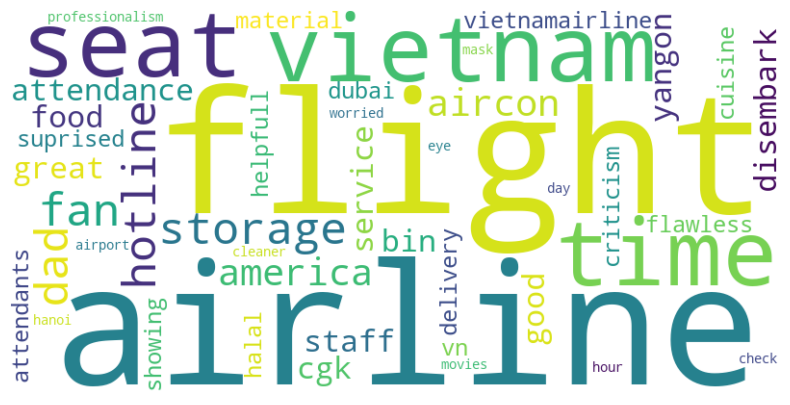

In [23]:
#1 Latent Dirichlet Allocation (LDA):
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 5  # Change this value according to your preference
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(text_matrix)
lda_topics = get_top_words(lda, vectorizer.get_feature_names_out())

# Extract word lists from LDA model
feature_names = vectorizer.get_feature_names_out()
lda_result = []
for topic_idx, topic in enumerate(lda.components_):
    top_words_indices = topic.argsort()[:-11:-1]
    top_words = [feature_names[i] for i in top_words_indices]
    lda_result.append(top_words)

#1 Print top words
print("Result 1: List of topics from LDA")
print_top_words(lda, vectorizer.get_feature_names_out())
# #2 Calculate word frequencY
# #############################################
# word_frequencies = {}
# for topic_idx, topic in enumerate(lda_result):
#     for word in topic:
#         if word in word_frequencies:
#             word_frequencies[word]['Frequency'] += text_data.str.count(word).sum()
#             if (topic_idx + 1) not in word_frequencies[word]['Topics']:
#                 word_frequencies[word]['Topics'].append(topic_idx + 1)
#         else:
#             word_frequencies[word] = {'Frequency': text_data.str.count(word).sum(), 'Topics': [topic_idx + 1]}

# Create DataFrame for word frequencies
word_freq_table = pd.DataFrame.from_dict(word_frequencies, orient='index')
word_freq_table.index.name = 'Word'
word_freq_table.reset_index(inplace=True)
word_freq_table.rename(columns={'index': 'Word', 'Frequency': 'Frequency', 'Topics': 'Topics'}, inplace=True)
word_freq_table['Topics'] = word_freq_table['Topics'].apply(lambda x: ', '.join(map(str, x)))

# Sort the DataFrame by frequency in descending order
word_freq_table = word_freq_table.sort_values(by='Frequency', ascending=False)

# Reset the index of the DataFrame
word_freq_table = word_freq_table.reset_index(drop=True)
# Display word frequencies table
print("Result 2: Word Frequencies Table LDA:")
print(word_freq_table)

####################################################################################

# #3 Plot the topics for each algorithm
# print("Result 3: Words frequency in Topics LDA")
# plot_top_words(lda, feature_names, title="Words frequency in Topics LDA")

#4 print word cloud
print("Result 4: Word Cloud of LDA")
generate_word_cloud(lda_topics)